In [1]:
import os
from PIL import Image
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [277]:
path = "./train_test_inputs/kitti_eigen_test_files_with_gt.txt"

In [278]:
with open(path, 'r') as f:
    filenames = f.readlines()

In [279]:
def remove_leading_slash(s):
    if s[0] == '/' or s[0] == '\\':
        return s[1:]
    return s

In [280]:
data_path = '../KITTI_Dense_Depth'
gt_path = '../data_depth_annotated/train'

In [281]:
for index, item in enumerate(filenames):
    image_path = os.path.join(data_path, remove_leading_slash(item.split()[0]))
    path_split = image_path.split('/')
    gt = os.path.join(gt_path, os.path.join(path_split[3], 'proj_depth/groundtruth/image_02',path_split[-1]))
    
    if os.path.exists(gt) and os.path.exists(image_path):
        print(image_path)
        print(gt)

../KITTI_Dense_Depth/2011_09_26/2011_09_26_drive_0009_sync/image_02/data/0000000016.png
../data_depth_annotated/train/2011_09_26_drive_0009_sync/proj_depth/groundtruth/image_02/0000000016.png
../KITTI_Dense_Depth/2011_09_26/2011_09_26_drive_0009_sync/image_02/data/0000000032.png
../data_depth_annotated/train/2011_09_26_drive_0009_sync/proj_depth/groundtruth/image_02/0000000032.png
../KITTI_Dense_Depth/2011_09_26/2011_09_26_drive_0009_sync/image_02/data/0000000048.png
../data_depth_annotated/train/2011_09_26_drive_0009_sync/proj_depth/groundtruth/image_02/0000000048.png
../KITTI_Dense_Depth/2011_09_26/2011_09_26_drive_0009_sync/image_02/data/0000000064.png
../data_depth_annotated/train/2011_09_26_drive_0009_sync/proj_depth/groundtruth/image_02/0000000064.png
../KITTI_Dense_Depth/2011_09_26/2011_09_26_drive_0009_sync/image_02/data/0000000080.png
../data_depth_annotated/train/2011_09_26_drive_0009_sync/proj_depth/groundtruth/image_02/0000000080.png
../KITTI_Dense_Depth/2011_09_26/2011_09_

In [293]:
4 % 4

0

### choose image for test

In [160]:
gt = '../data_depth_annotated/train/2011_09_30_drive_0027_sync/proj_depth/groundtruth/image_02/0000000656.png'
im = '../KITTI_Dense_Depth/2011_09_30/2011_09_30_drive_0027_sync/image_02/data/0000000656.png'
pred = 'output.png'

In [44]:
def crop_image(image):
    height = image.height
    width = image.width
    top_margin = int(height - 352)
    left_margin = int((width - 1216) / 2)
#     depth_gt = depth_gt.crop((left_margin, top_margin, left_margin + 1216, top_margin + 352))
    image = image.crop((left_margin, top_margin, left_margin + 1216, top_margin + 352))
    return image

In [45]:
def add_margin(pil_img, right, bottom, color):
    width, height = pil_img.size
    new_width = width + right
    new_height = height + bottom
    result = Image.new(pil_img.mode, (new_width, new_height), color)
    result.paste(pil_img, (0, 0))
    return result

In [46]:
# add padding following FFC rule
def pad(image):
    height = image.height
    width = image.width
    add_height = height % 4
    add_width = width % 4
    
    if add_height == 1:
        add_height = 3
    elif add_height == 3:
        add_height = 1
        
    if add_width == 1:
        add_width = 3
    elif add_width == 3:
        add_width = 1
    image = add_margin(image, add_width, add_height, (0, 0, 0))
    return image   

In [68]:
def read_depth(depth_path):
    # groundtruth
    depth_gt = Image.open(depth_path)
    depth_gt = np.asarray(depth_gt, dtype=np.float32)
    depth_gt = depth_gt / 256.0
    return depth_gt

def read_pred(filename):
    # remove padding to match the shape of image
    # loads depth map D from png file
    # and returns it as a numpy array,
    # for details see readme.txt
    depth = Image.open(filename)
#     depth = crop_image(depth)
    depth_png = np.array(depth, dtype=int)
    # make sure we have a proper 16bit depth map here.. not 8bit!
    assert(np.max(depth_png) > 255)

    depth = depth_png.astype(np.float) / 256.
    depth[depth_png == 0] = -1.
    return depth

In [161]:
# crop for prediction
image = Image.open(im)
image = pad(image)
image.save('input.png')

### Run after inference

In [162]:
gt = read_depth(gt)
pred = read_pred(pred)
im = Image.open(im)

/tmp/ipykernel_25360/3790527187.py:19: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  depth = depth_png.astype(np.float) / 256.


In [163]:
h, w = gt.shape
pred = pred[: h, : w]

In [164]:
diff = pred - gt
valid_mask = np.logical_and(gt > 0.0, gt < 80.0)

In [165]:
from utils import compute_errors
compute_errors(gt[valid_mask], pred[valid_mask])

{'a1': 0.9938202688890636,
 'a2': 0.9991194276279581,
 'a3': 0.9993552952276122,
 'abs_rel': 0.06467313551984934,
 'rmse': 1.9090047663317675,
 'log_10': 0.029063060138310233,
 'rmse_log': 0.08140211702942103,
 'silog': 6.668105061004552,
 'sq_rel': 0.12197947450553889}

In [166]:
error = np.abs(np.multiply(diff, valid_mask))

### Positive and negative error

In [167]:
# pred is larger than gt
positive_valid_mask = np.logical_and(diff > 0.0, diff < 80.0)
positive_error = np.abs(np.multiply(np.multiply(diff, valid_mask), positive_valid_mask))

In [168]:
# pred is smaller than gt
negative_valid_mask = np.logical_and(diff < 0.0, diff > -80.0)
negative_error = np.abs(np.multiply(np.multiply(diff, valid_mask), negative_valid_mask))

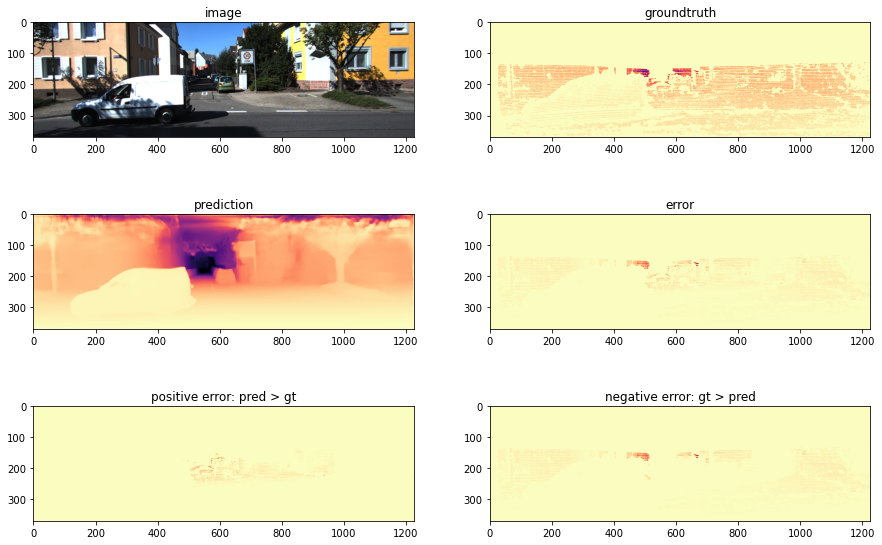

In [169]:
plt.figure(figsize=(15, 10))
plt.subplot(321)
plt.title('image')
plt.imshow(im)

# plt.figure()
plt.subplot(322)
plt.title('groundtruth')
plt.imshow(gt, cmap='magma_r')

# plt.figure()
plt.subplot(323)
plt.title('prediction')
plt.imshow(pred, cmap='magma_r')

# plt.figure()
plt.subplot(324)
plt.title('error')
plt.imshow(error, cmap='magma_r')

# plt.figure()
plt.subplot(325)
plt.title('positive error: pred > gt')
plt.imshow(positive_error, cmap='magma_r')

# plt.figure()
plt.subplot(326)
plt.title('negative error: gt > pred')
plt.imshow(negative_error, cmap='magma_r')

plt.show()

In [170]:
np.sum(error)/np.sum(valid_mask)

1.1012996059045523

In [171]:
np.max(error)

34.08203125